In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objs as go

#from trading_system_copy import TradingSystem
#from trading_optimization_copy import OptimizeTradingSystem

from trading_system import TradingSystem as TradingSystem



In [2]:
cointegration_params = {
    "validation_size": 250,
    "test_size": 250,
    "strategy": "cointegration",
    "cointegration_rolling_window": 250
}

forecasting_params = {
    "strategy": "forecasting",
    "validation_size": 250,
    "test_size": 250,
}

cointegration_study_params = {
    "rolling_window_range": [5,60,5],
    "lower_threshold_range": [0.0,2.0,0.01],
}

forecasting_study_params = {
    "rolling_window_range": [5,60,5],
    "lower_threshold_range": [0.0,2.0,0.01],
}

validation_size = 250
test_size = 250
window_size = 5
model = "ann_long"
models = ["arima", "ann", "vecm", "tvecm_long_t1", "ols"]
pairs = ["ttf-the", "ttf-nbp", "the-nbp"]
window_sizes = [5]
volatility_models = ["rolling", "sGARCH_norm","sGARCH_sstd", "fiGARCH_sstd", "gjrGARCH_sstd", "sGARCH_norm_21", "sGARCH_sstd_21",  "gjrGARCH_sstd_21"]

df = pd.DataFrame()

for model in models:
    for window_size in window_sizes:
        for pair in pairs:
            for vol_model in volatility_models:

                hub1_name = pair.split("-")[0]
                hub2_name = pair.split("-")[1]

                params = cointegration_params if model == "ols" else forecasting_params
                study_params = cointegration_study_params if model == "ols" else forecasting_study_params

                
                params["hub1_name"] = hub1_name
                params["hub2_name"] = hub2_name
                params["model"] = model
                params["window_size"] = window_size

                study_params["volatility"] = vol_model
                study_params["criteria"] = "mean_returns"
                study_params["min_trades"] = 10
                study_params["verbose"] = False
                study_params["plot"] = False

                if model in ["naive", "perfect_information"]:
                    params["model"] = "vecm" # not used, just need a model for the algo to work
                    params["mode"] = "test"
                    vol_model = "sGARCH_norm" # not used, just need a model for the algo to work 
                    test_ts = TradingSystem(**params)
                    test_ts.run_trading_system(volatility=vol_model,
                                        rolling_window=best_rolling_window, 
                                        lower_threshold=100, 
                                        special_strategy=model, 
                                        verbose=False, 
                                        plot=False)
                    vol_model = " "
                else:
                    params["mode"] = "validation"
                    validation_ts = TradingSystem(**params)
                    best_profit, best_rolling_window, best_lower_threshold = validation_ts.study(**study_params)

                    params["mode"] = "test"
                    test_ts = TradingSystem(**params)
                    test_ts.run_trading_system(volatility=vol_model,
                                        rolling_window=best_rolling_window, 
                                        lower_threshold=best_lower_threshold, 
                                        special_strategy="no", 
                                        verbose=False, 
                                        plot=False)


                mean = f"{test_ts.get_returns_stats()[0]:.3f}"
                std = f"{test_ts.get_returns_stats()[1]:.3f}"

                CI = test_ts.get_returns_stats()[3]
                CI_f = f"{CI[0]:.3f}% -{CI[1]:.3f}%"

                trade_rate = f"{(1- test_ts.get_trade_rates()['no_trade_rate_returns'])*100:.1f}"

                data = {
                    "Model": model,
                    "Pair": f"{hub1_name} - {hub2_name}",
                    "Volatility_model": vol_model,
                    "Window_size": window_size,
                    "Rolling_window": best_rolling_window,
                    "Threshold": best_lower_threshold,
                    "Mean": mean,
                    "Standard_Deviation": std,
                    "Confidence_Interval": CI_f,
                    "Trade_rate": trade_rate
                }

                # Convert the dictionary into a pandas dataframe
                df = pd.concat([df, pd.DataFrame([data])])


In [3]:
sorted_df = df.sort_values(by=["Pair", "Mean"], ascending=False)

In [4]:
pd.set_option('display.max_rows', None)
sorted_df

,Model,Pair,Volatility_model,Window_size,Rolling_window,Threshold,Mean,Standard_Deviation,Confidence_Interval,Trade_rate
0,tvecm_long_t1,ttf - the,sGARCH_norm,5,None,0.07,0.178,0.595,0.104% -0.251%,86.8
0,tvecm_long_t1,ttf - the,sGARCH_sstd,5,None,0.06,0.178,0.595,0.104% -0.251%,86.8
0,tvecm_long_t1,ttf - the,fiGARCH_sstd,5,None,0.06,0.178,0.595,0.104% -0.251%,86.8
0,tvecm_long_t1,ttf - the,gjrGARCH_sstd,5,None,0.06,0.178,0.595,0.104% -0.251%,86.8
0,tvecm_long_t1,ttf - the,sGARCH_norm_21,5,None,0.07,0.178,0.595,0.104% -0.251%,86.8
0,tvecm_long_t1,ttf - the,sGARCH_sstd_21,5,None,0.06,0.178,0.595,0.104% -0.251%,86.8
0,tvecm_long_t1,ttf - the,gjrGARCH_sstd_21,5,None,0.06,0.178,0.595,0.104% -0.251%,86.8
0,tvecm_long_t1,ttf - the,rolling,5,5,0.15,0.172,0.599,0.098% -0.246%,89.2
0,vecm,ttf - the,fiGARCH_sstd,5,None,0.11,0.149,0.597,0.075% -0.223%,84.0
0,vecm,ttf - the,sGARCH_sstd_21,5,None,0.11,0.149,0.597,0.075% -0.223%,84.0


In [17]:
%pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [5]:
df['Model'] = df['Model'].astype(str)
df['Pair'] = df['Pair'].astype(str)
df['Volatility_model'] = df['Volatility_model'].astype(str)
df['Confidence_Interval'] = df['Confidence_Interval'].astype(str)

# Use openpyxl to export with specific formatting
df.to_excel("trading_comparison.xlsx", index=False, engine='openpyxl')


In [6]:
# List of pairs and models to filter by
pairs = ['ttf - the', 'ttf - nbp', 'the - nbp']
#models = ['ols', 'arima', 'vecm', 'tvecm_long_t1', 'ann', 'naive', 'perfect_information']
models = ['ols', 'arima', 'vecm', 'tvecm_long_t1', 'ann']

# Dictionary to hold the filtered dataframes for each pair
filtered_dataframes = {}

for pair in pairs:
    print(f"Pair: {pair}")
    # Filter the dataframe for the specific pair
    df_pair = df[df['Pair'] == pair]
    
    # DataFrame to store the highest performing GARCH and rolling model for each of the specified models
    df_filtered = pd.DataFrame()
    
    for model in models:
        # Filter for the specific model
        df_model = df_pair[df_pair['Model'] == model]
        
        if not df_model.empty:
            # Find the highest performing GARCH model based on 'Mean'
            garch_model = df_model[df_model['Volatility_model'].str.contains('GARCH')].sort_values(by='Mean', ascending=False).head(1)
            
            # Find the rolling model
            rolling_model = df_model[df_model['Volatility_model'].str.contains('rolling')].sort_values(by='Mean', ascending=False).head(1)

            
            # Append the highest performing GARCH and rolling models to the filtered DataFrame
            df_filtered = pd.concat([df_filtered, garch_model, rolling_model])

        if model in ["naive", "perfect_information"]:

            df_filtered = pd.concat([df_filtered, df_model.head(1)])
    
    # Store the filtered DataFrame in the dictionary
    filtered_dataframes[pair] = df_filtered

# Now, 'filtered_dataframes' contains a separate filtered DataFrame for each pair
# Example: Access the filtered DataFrame for 'ttf-the' pair
filtered_dataframes['ttf - the']


Pair: ttf - the
Pair: ttf - nbp
Pair: the - nbp


,Model,Pair,Volatility_model,Window_size,Rolling_window,Threshold,Mean,Standard_Deviation,Confidence_Interval,Trade_rate
0,ols,ttf - the,fiGARCH_sstd,5,None,0.09,0.082,0.636,0.003% -0.160%,94.0
0,ols,ttf - the,rolling,5,5,0.88,0.064,0.573,-0.007% -0.135%,78.8
0,arima,ttf - the,sGARCH_norm,5,None,0.30,0.003,0.224,-0.025% -0.030%,34.8
0,arima,ttf - the,rolling,5,20,0.39,0.001,0.463,-0.057% -0.058%,51.6
0,vecm,ttf - the,fiGARCH_sstd,5,None,0.11,0.149,0.597,0.075% -0.223%,84.0
0,vecm,ttf - the,rolling,5,40,0.17,0.136,0.590,0.063% -0.209%,78.8
0,tvecm_long_t1,ttf - the,sGARCH_norm,5,None,0.07,0.178,0.595,0.104% -0.251%,86.8
0,tvecm_long_t1,ttf - the,rolling,5,5,0.15,0.172,0.599,0.098% -0.246%,89.2
0,ann,ttf - the,sGARCH_norm,5,None,0.69,0.130,0.514,0.066% -0.193%,61.6
0,ann,ttf - the,rolling,5,5,1.06,0.136,0.583,0.064% -0.208%,69.2


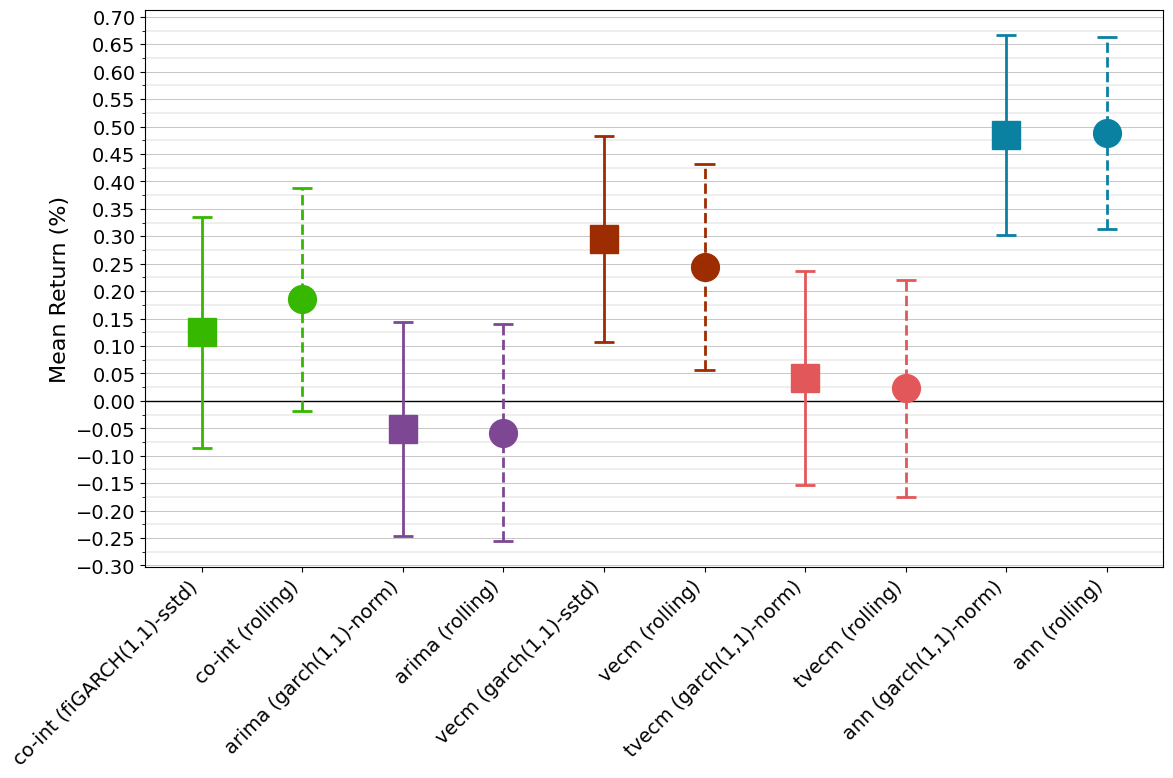

In [15]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Set the pair as a variable
pair = 'the - nbp'  # Change this to any other pair, e.g., 'ttf - nbp', 'the - nbp'

plt.rc('font', size=14)  # Set default text size
plt.rc('axes', titlesize=18)  # Font size of the title
plt.rc('axes', labelsize=16)  # Font size of the x and y labels
plt.rc('xtick', labelsize=14)  # Font size of the x tick labels
plt.rc('ytick', labelsize=14)  # Font size of the y tick labels
plt.rc('legend', fontsize=14)  # Font size of the legend

# Assuming 'filtered_dataframes' already exists and contains the filtered DataFrame for the selected pair
df_plot = filtered_dataframes[pair]

# Adjust the Volatility_model column for GARCH models only
def map_volatility_model(vol_model):
    if 'GARCH' in vol_model:
        # Normalize and format GARCH models
        if vol_model.startswith('sGARCH'):
            base = 'garch'
        else:
            base = vol_model.split('_')[0]
        
        # Determine the order (2,1) or (1,1)
        order = '(2,1)' if '21' in vol_model else '(1,1)'
        
        # Keep the suffix if present
        suffix = '-' + vol_model.split('_')[1] if '_' in vol_model else ''
        
        return f"{base}{order}{suffix}"
    else:
        # Leave non-GARCH models unchanged
        return vol_model

# Apply the mapping function to the Volatility_model column
df_plot['Volatility_model_mapped'] = df_plot['Volatility_model'].apply(map_volatility_model)

# Update the Model column to capitalize and rename specific models
def map_model_name(model):
    if model == 'ann':
        return 'ann'
    elif model == 'vecm':
        return 'vecm'
    elif model == 'tvecm_long_t1':
        return 'tvecm'
    elif model == 'ols':
        return 'co-int'
    elif model == 'naive':
        return 'naïve'
    elif model == 'perfect_information':
        return 'Perfect information'
    else:
        return model

# Apply the mapping to the Model column
df_plot['Model_mapped'] = df_plot['Model'].apply(map_model_name)


df_plot['models_plot'] = np.where(
    df_plot['Volatility_model_mapped'] == " ",
    df_plot['Model_mapped'],
    df_plot['Model_mapped'] + " (" + df_plot['Volatility_model_mapped'] + ")"
)

means_plot = df_plot['Mean'].astype(float)
ci_lower_err_plot = means_plot - df_plot['Confidence_Interval'].str.split(' ').str[0].str.rstrip('%').astype(float)
ci_upper_err_plot = df_plot['Confidence_Interval'].str.split(' ').str[1].str[1:].str.rstrip('%').astype(float) - means_plot

# Generate a unique color for each model type with the updated names
unique_models = df_plot['models_plot'].str.split(" ").str[0].unique()

# Custom colors for a modern and professional look
colors = ['#36b700', '#7e4794', '#9d2c00', '#e25759', '#0b81a2', '#59a89c', '#f0c571']

# Map colors to model types
model_colors = {model: colors[i % len(colors)] for i, model in enumerate(unique_models)}

# Define markers and line styles for GARCH and rolling models
marker_styles = {'GARCH': 's', 'rolling': 'o'}  # 'o' for GARCH, '^' for rolling
line_styles = {'GARCH': '-', 'rolling': '--'}  # Different line styles for error bars
marker_size = 20
lw = 2
cap_width = 0.1  # Width for horizontal cap lines

y_major_ticks = np.arange(-0.5, 1.1, 0.05)  # Major ticks (adjust the step for spacing)
y_minor_ticks = np.arange(-0.5, 1.1, 0.025)  # Minor ticks (finer spacing)

plt.figure(figsize=(12, 8))

# Set y-ticks for major and minor gridlines
plt.yticks(y_major_ticks)
plt.gca().yaxis.set_minor_locator(plt.MultipleLocator(0.025))  # Set minor ticks

plt.axhline(0, color='black', linewidth=1, linestyle='-')  # Horizontal line at y=0

# Add major and minor gridlines
plt.grid(axis='y', linestyle='-', linewidth=0.5, which='major')  # Major gridlines
plt.grid(axis='y', linestyle='-', linewidth=0.3, which='minor')

for i, (model, mean, vol_model) in enumerate(zip(df_plot['models_plot'], means_plot, df_plot['Volatility_model_mapped'])):
    base_model = model.split(" ")[0]  # Extract base model name (e.g., 'COINTEGRATION', 'VECM')
    marker = marker_styles['rolling'] if 'rolling' in vol_model else marker_styles['GARCH']
    line_style = line_styles['rolling'] if 'rolling' in vol_model else line_styles['GARCH']
    
    # Plot the mean point
    plt.plot(model, mean, marker=marker, color=model_colors[base_model], markersize=marker_size)
    
    # Plot the error bars as custom lines
    plt.vlines(
        model, mean - ci_lower_err_plot.iloc[i], mean + ci_upper_err_plot.iloc[i],
        colors=model_colors[base_model], linestyles=line_style, lw=lw
    )
    
    # Add horizontal caps at the ends of the error bars
    plt.hlines(
        y=mean - ci_lower_err_plot.iloc[i], xmin=i - cap_width, xmax=i + cap_width,
        colors=model_colors[base_model], linestyles="-", lw = lw
    )
    plt.hlines(
        y=mean + ci_upper_err_plot.iloc[i], xmin=i - cap_width, xmax=i + cap_width,
        colors=model_colors[base_model], linestyles="-", lw = lw
    )

# Adding labels and title

plt.ylabel('Mean Return (%)')
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.tight_layout()
plt.show()


In [16]:
df_plot

,Model,Pair,Volatility_model,Window_size,Rolling_window,Threshold,Mean,Standard_Deviation,Confidence_Interval,Trade_rate,Volatility_model_mapped,Model_mapped,models_plot
0,ols,the - nbp,fiGARCH_sstd,5,None,0.48,0.126,1.700,-0.085% -0.336%,92.4,"fiGARCH(1,1)-sstd",co-int,"co-int (fiGARCH(1,1)-sstd)"
0,ols,the - nbp,rolling,5,15,0.93,0.185,1.638,-0.018% -0.388%,88.8,rolling,co-int,co-int (rolling)
0,arima,the - nbp,sGARCH_norm,5,None,0.01,-0.052,1.576,-0.247% -0.144%,98.4,"garch(1,1)-norm",arima,"arima (garch(1,1)-norm)"
0,arima,the - nbp,rolling,5,5,0.01,-0.058,1.598,-0.256% -0.140%,100.0,rolling,arima,arima (rolling)
0,vecm,the - nbp,sGARCH_sstd,5,None,0.04,0.295,1.517,0.107% -0.483%,89.2,"garch(1,1)-sstd",vecm,"vecm (garch(1,1)-sstd)"
0,vecm,the - nbp,rolling,5,10,0.10,0.244,1.520,0.056% -0.432%,87.6,rolling,vecm,vecm (rolling)
0,tvecm_long_t1,the - nbp,sGARCH_norm,5,None,0.12,0.041,1.573,-0.154% -0.236%,99.6,"garch(1,1)-norm",tvecm,"tvecm (garch(1,1)-norm)"
0,tvecm_long_t1,the - nbp,rolling,5,55,0.13,0.023,1.598,-0.175% -0.221%,100.0,rolling,tvecm,tvecm (rolling)
0,ann,the - nbp,sGARCH_norm,5,None,0.06,0.485,1.463,0.303% -0.666%,93.6,"garch(1,1)-norm",ann,"ann (garch(1,1)-norm)"
0,ann,the - nbp,rolling,5,10,0.23,0.488,1.416,0.313% -0.664%,86.0,rolling,ann,ann (rolling)
